Assignment 3 NLP: Word embedding

In [9]:
#BERT model

import pandas as pd

df = pd.read_csv("NikeProductDescriptions.csv")

In [10]:
print(df.columns)

Index(['Title', 'Subtitle', 'Product Description'], dtype='object')


In [11]:
#filtering by subtitles
target_subtitles = [
    "Men's Shoes",
    "Men's T-Shirt",
    "Women's Shoes",
    "Skate Shoes",
    "Older Kids' T-Shirt"
]

filtered_df = df[
    df['Subtitle'].isin(target_subtitles) |
    df['Subtitle'].str.contains("Shorts", case=False, na=False)
].copy()

filtered_df.loc[filtered_df['Subtitle'].str.contains("Shorts", case=False, na=False), 'Subtitle'] = "Shorts"

In [12]:
print(filtered_df['Subtitle'].unique())

["Men's Shoes" 'Skate Shoes' 'Shorts' "Men's T-Shirt" "Women's Shoes"
 "Older Kids' T-Shirt"]


In [13]:
!pip uninstall torch torchvision torchaudio transformers -y
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
!pip install transformers

Found existing installation: torch 2.7.1+cpu
Uninstalling torch-2.7.1+cpu:
  Successfully uninstalled torch-2.7.1+cpu
Found existing installation: torchvision 0.22.1+cpu
Uninstalling torchvision-0.22.1+cpu:
  Successfully uninstalled torchvision-0.22.1+cpu
Found existing installation: torchaudio 2.7.1+cpu
Uninstalling torchaudio-2.7.1+cpu:
  Successfully uninstalled torchaudio-2.7.1+cpu
Found existing installation: transformers 4.53.1
Uninstalling transformers-4.53.1:
  Successfully uninstalled transformers-4.53.1


You can safely remove it manually.
You can safely remove it manually.


Looking in indexes: https://download.pytorch.org/whl/cpu
  Using cached https://download.pytorch.org/whl/cpu/torch-2.7.1%2Bcpu-cp311-cp311-win_amd64.whl.metadata (27 kB)
  Using cached https://download.pytorch.org/whl/cpu/torchvision-0.22.1%2Bcpu-cp311-cp311-win_amd64.whl.metadata (6.3 kB)
  Using cached https://download.pytorch.org/whl/cpu/torchaudio-2.7.1%2Bcpu-cp311-cp311-win_amd64.whl.metadata (6.8 kB)
Using cached https://download.pytorch.org/whl/cpu/torch-2.7.1%2Bcpu-cp311-cp311-win_amd64.whl (216.0 MB)
Using cached https://download.pytorch.org/whl/cpu/torchvision-0.22.1%2Bcpu-cp311-cp311-win_amd64.whl (1.7 MB)
Using cached https://download.pytorch.org/whl/cpu/torchaudio-2.7.1%2Bcpu-cp311-cp311-win_amd64.whl (2.5 MB)
  Using cached transformers-4.53.1-py3-none-any.whl.metadata (40 kB)
Using cached transformers-4.53.1-py3-none-any.whl (10.8 MB)


In [14]:
from transformers import BertTokenizer, BertModel
import torch

In [15]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

In [16]:
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension --sys-prefix

usage: jupyter [-h] [--version] [--config-dir] [--data-dir] [--runtime-dir]
               [--paths] [--json] [--debug]
               [subcommand]

Jupyter: Interactive Computing

positional arguments:
  subcommand     the subcommand to launch

options:
  -h, --help     show this help message and exit
  --version      show the versions of core jupyter packages and exit
  --config-dir   show Jupyter config dir
  --data-dir     show Jupyter data dir
  --runtime-dir  show Jupyter runtime dir
  --paths        show all Jupyter paths. Add --json for machine-readable
                 format.
  --json         output paths as machine-readable json
  --debug        output debug information about paths

Available subcommands: console dejavu events execute kernel kernelspec lab
labextension labhub migrate nbconvert notebook qtconsole run script server
troubleshoot trust

Jupyter command `jupyter-nbextension` not found.


In [17]:
#Creating an embedding vector
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')
model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [18]:
def get_bert_embedding(text):
    with torch.no_grad():
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
        outputs = model(**inputs)
        return outputs.last_hidden_state[:, 0, :].squeeze().numpy()

In [20]:
embeddings = []
for desc in tqdm(df['Product Description'], desc="Generating BERT embeddings"):
    embeddings.append(get_bert_embedding(str(desc)))

Generating BERT embeddings: 100%|████████████████████████████████████████████████████| 400/400 [00:59<00:00,  6.74it/s]


In [21]:
import numpy as np
X = np.vstack(embeddings)

In [22]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

In [23]:
le = LabelEncoder()
labels = le.fit_transform(df['Subtitle'])

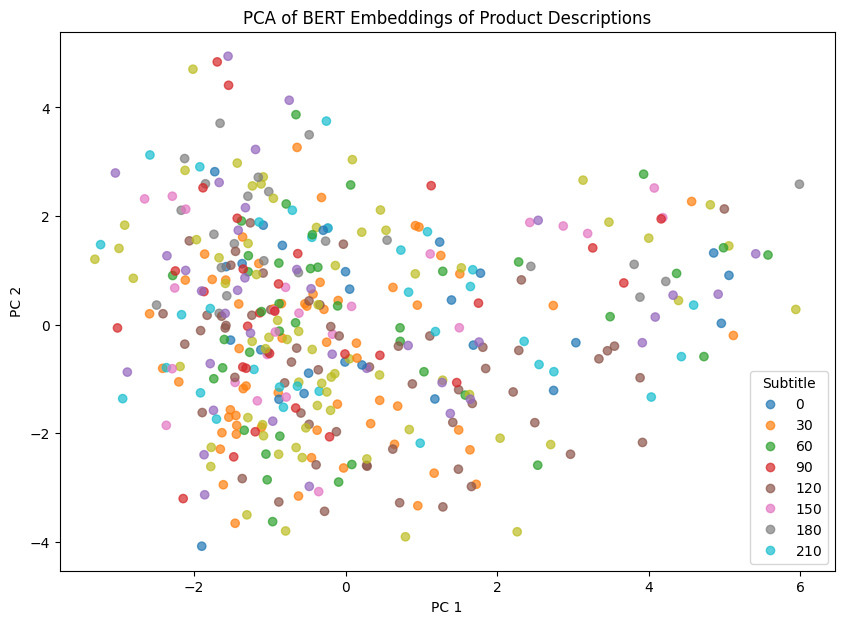

In [26]:
#Plot
plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='tab10', alpha=0.7)

handles, labels_ = scatter.legend_elements()
plt.legend(handles=handles, labels=labels_, title="Subtitle")

plt.title("PCA of BERT Embeddings of Product Descriptions")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.show()

In [27]:
#GitHub
mkdir Nike-BERT-Embedding
cd Nike-BERT-Embedding

SyntaxError: invalid syntax (2442569823.py, line 2)